# Kmeans Clustering

Online retail is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail. Building RFM Clusters to find best set of customers

In [133]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import scale
from sklearn.cluster import KMeans

# for hierarichal clustering
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree


### Reading the data set

In [134]:
# reading the dataset
retail=pd.read_csv("Online+Retail.csv")
retail.InvoiceDate=pd.to_datetime(retail['InvoiceDate'],format="%d-%m-%Y %H:%M")
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


### Data Quality check and cleaning

In [135]:
print(retail.shape,"\n\n\n")
print(retail.describe(),"\n\n\n")
print(retail.info())

(541909, 8) 



            Quantity      UnitPrice     CustomerID
count  541909.000000  541909.000000  406829.000000
mean        9.552250       4.611114   15287.690570
std       218.081158      96.759853    1713.600303
min    -80995.000000  -11062.060000   12346.000000
25%         1.000000       1.250000   13953.000000
50%         3.000000       2.080000   15152.000000
75%        10.000000       4.130000   16791.000000
max     80995.000000   38970.000000   18287.000000 



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   Custom

In [136]:
# handling null values
retail.isnull().sum()*100/retail.shape[0]


InvoiceNo       0.000000
StockCode       0.000000
Description     0.268311
Quantity        0.000000
InvoiceDate     0.000000
UnitPrice       0.000000
CustomerID     24.926694
Country         0.000000
dtype: float64

In [137]:
# dropping the na cells
order_wise=retail.dropna()

In [138]:
order_wise.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

### Extracting Recency Frequency and Monetory columns from the data

In [139]:
order_wise.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [140]:
# Extracting amount by multiplying unit price by quantity

amount=pd.DataFrame(order_wise.Quantity*order_wise.UnitPrice,columns=['Amount'])
amount.head()

,Amount
0,15.30
1,20.34
2,22.00
3,20.34
4,20.34


In [141]:
# merging with Order_wise
order_wise=pd.concat([order_wise,amount],axis=1,ignore_index=False)

### Monetory function

In [142]:

# Finding total maount spent per customer
monetary=order_wise.groupby("CustomerID").Amount.sum()
monetary=monetary.reset_index()
monetary.head()

,CustomerID,Amount
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


### Frequency Value

In [143]:
frequency=order_wise[['CustomerID','InvoiceNo']]

In [144]:
# getting the count of( orders made by each customer based on the customerID
k=frequency.groupby("CustomerID").InvoiceNo.count()
k=pd.DataFrame(k)
k=k.reset_index()
k.columns = ["CustomerID", "Frequency"]
k.head()

,CustomerID,Frequency
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


### Merging Amount and frequency

In [145]:
master=monetary.merge(k,on='CustomerID',how='inner')
master.head()

,CustomerID,Amount,Frequency
0,12346.0,0.00,2
1,12347.0,4310.00,182
2,12348.0,1797.24,31
3,12349.0,1757.55,73
4,12350.0,334.40,17


### Recency value

In [146]:
#filtering data for CustomerID and Invoice date
recency=order_wise[['CustomerID','InvoiceDate']]
#finding the maximum date
maximum=max(recency.InvoiceDate)

# adding 1 to maximum date so that the max date would have 1 as the difference and not zero
maximum=maximum+pd.DateOffset(days=1)
recency['diff']=maximum-recency['InvoiceDate']
recency.head()

<ipython-input-146-9984d55e13b2>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recency['diff']=maximum-recency['InvoiceDate']


,CustomerID,InvoiceDate,diff
0,17850.0,2010-12-01 08:26:00,374 days 04:24:00
1,17850.0,2010-12-01 08:26:00,374 days 04:24:00
2,17850.0,2010-12-01 08:26:00,374 days 04:24:00
3,17850.0,2010-12-01 08:26:00,374 days 04:24:00
4,17850.0,2010-12-01 08:26:00,374 days 04:24:00


In [147]:
#recency by customer ID
df = pd.DataFrame(recency.groupby('CustomerID').min('diff'))
df=df.reset_index()
df.columns=["CustomerID","InvoiceDate","Recency"]
df=df.drop('InvoiceDate',axis=1)
df.head()

,CustomerID,Recency
0,12346.0,326 days 02:33:00
1,12347.0,2 days 20:58:00
2,12348.0,75 days 23:37:00
3,12349.0,19 days 02:59:00
4,12350.0,310 days 20:49:00


## RFM combined dataframe

In [148]:
RFM=master.merge(df,on='CustomerID',how='inner')
RFM.head()

,CustomerID,Amount,Frequency,Recency
0,12346.0,0.00,2,326 days 02:33:00
1,12347.0,4310.00,182,2 days 20:58:00
2,12348.0,1797.24,31,75 days 23:37:00
3,12349.0,1757.55,73,19 days 02:59:00
4,12350.0,334.40,17,310 days 20:49:00


### Outlier Treatment

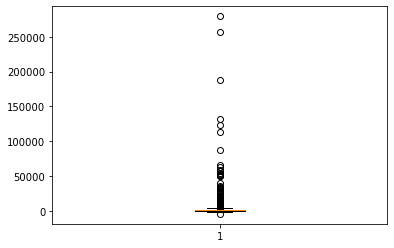

In [149]:
plt.boxplot(RFM.Amount)
Q1=RFM.Amount.quantile(0.25)
Q3=RFM.Amount.quantile(0.75)
IQR=Q3-Q1
RFM=RFM[(RFM.Amount>=Q1-1.5*IQR) & (RFM.Amount<=Q3+1.5*IQR)]

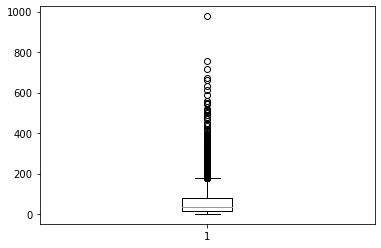

In [150]:
plt.boxplot(RFM.Frequency)
Q1=RFM.Amount.quantile(0.25)
Q3=RFM.Amount.quantile(0.75)
IQR=Q3-Q1
RFM=RFM[(RFM.Amount>=Q1-1.5*IQR) & (RFM.Amount<=Q3+1.5*IQR)]

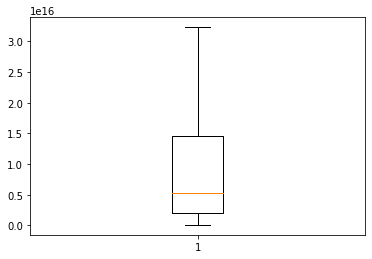

In [151]:
plt.boxplot(RFM.Recency)
Q1=RFM.Recency.quantile(0.25)
Q3=RFM.Recency.quantile(0.75)
IQR=Q3-Q1
RFM=RFM[(RFM.Recency>=Q1-1.5*IQR) & (RFM.Recency<=Q3+1.5*IQR)]

In [152]:
RFM.head()

,CustomerID,Amount,Frequency,Recency
0,12346.0,0.00,2,326 days 02:33:00
2,12348.0,1797.24,31,75 days 23:37:00
3,12349.0,1757.55,73,19 days 02:59:00
4,12350.0,334.40,17,310 days 20:49:00
5,12352.0,1545.41,95,36 days 22:13:00


### Scaling Data

In [153]:
# standardise all parameters
RFM_norm1 = RFM.drop("CustomerID", axis=1)
RFM_norm1.Recency = RFM_norm1.Recency.dt.days

from sklearn.preprocessing import StandardScaler
standard_scaler = StandardScaler()
RFM_norm1 = standard_scaler.fit_transform(RFM_norm1)

In [154]:
RFM_norm1 = pd.DataFrame(RFM_norm1)
RFM_norm1.columns = ['Frequency','Amount','Recency']
RFM_norm1.head()

,Frequency,Amount,Recency
0,-1.162025,-0.819417,2.151086
1,1.715344,-0.363506,-0.271445
2,1.651801,0.296779,-0.811930
3,-0.626653,-0.583601,1.996661
4,1.312166,0.642642,-0.647855


## Hopkins Statistics:
The Hopkins statistic, is a statistic which gives a value which indicates the cluster tendency, in other words: how well the data can be clustered.

- If the value is between {0.01, ...,0.3}, the data is regularly spaced.

- If the value is around 0.5, it is random.

- If the value is between {0.7, ..., 0.99}, it has a high tendency to cluster.

In [155]:
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan
 
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [156]:
hopkins(RFM_norm1)

0.9551279743335026

## K-Means with different values of  K

## Silhouette Analysis

silhouette score}=(p-q)/max(p,q)

$p$ is the mean distance to the points in the nearest cluster that the data point is not a part of

$q$ is the mean intra-cluster distance to all the points in its own cluster.

* The value of the silhouette score range lies between -1 to 1. 

* A score closer to 1 indicates that the data point is very similar to other data points in the cluster, 

* A score closer to -1 indicates that the data point is not similar to the data points in its cluster.

In [157]:
from sklearn.metrics import silhouette_score
sse_ = []
for k in range(2, 15):
    kmeans = KMeans(n_clusters=k).fit(RFM_norm1)
    sse_.append([k, silhouette_score(RFM_norm1, kmeans.labels_)])

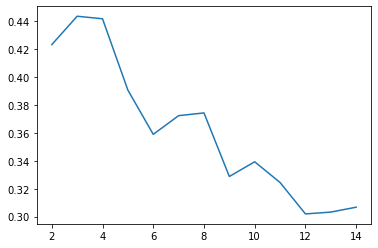

In [158]:
plt.plot(pd.DataFrame(sse_)[0], pd.DataFrame(sse_)[1]);

## Sum of Squared Distances

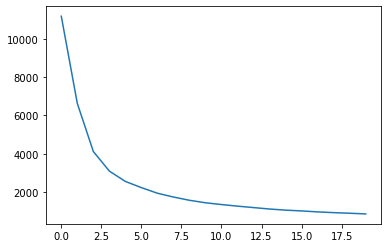

In [159]:
# sum of squared distances
ssd = []
for num_clusters in list(range(1,21)):
    model_clus = KMeans(n_clusters = num_clusters, max_iter=50)
    model_clus.fit(RFM_norm1)
    ssd.append(model_clus.inertia_)

plt.plot(ssd)

In [160]:
# analysis of clusters formed
RFM.index = pd.RangeIndex(len(RFM.index))
RFM_km = pd.concat([RFM, pd.Series(model_clus.labels_)], axis=1)
RFM_km.columns = ['CustomerID', 'Frequency', 'Amount', 'Recency', 'ClusterID']

RFM_km.Recency = RFM_km.Recency.dt.days
km_clusters_amount = 	pd.DataFrame(RFM_km.groupby(["ClusterID"]).Amount.mean())
km_clusters_frequency = 	pd.DataFrame(RFM_km.groupby(["ClusterID"]).Frequency.mean())
km_clusters_recency = 	pd.DataFrame(RFM_km.groupby(["ClusterID"]).Recency.mean())

In [161]:
df = pd.concat([pd.Series([0,1,2,3,4]), km_clusters_amount, km_clusters_frequency, km_clusters_recency], axis=1)
df.columns = ["ClusterID", "Amount_mean", "Frequency_mean", "Recency_mean"]
df.head()

,ClusterID,Amount_mean,Frequency_mean,Recency_mean
0,0.0,16.185022,195.383216,345.237885
1,1.0,55.771429,1163.208321,25.535714
2,2.0,44.345455,607.388182,189.981818
3,3.0,15.815789,222.846154,30.394737
4,4.0,19.781341,299.173032,267.087464


<AxesSubplot:xlabel='ClusterID', ylabel='Amount_mean'>

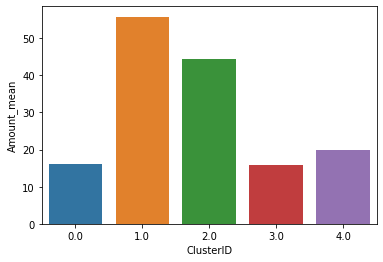

In [162]:
sns.barplot(x=df.ClusterID, y=df.Amount_mean)


<AxesSubplot:xlabel='ClusterID', ylabel='Frequency_mean'>

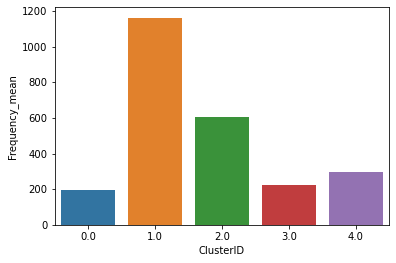

In [163]:
sns.barplot(x=df.ClusterID, y=df.Frequency_mean)

<AxesSubplot:xlabel='ClusterID', ylabel='Recency_mean'>

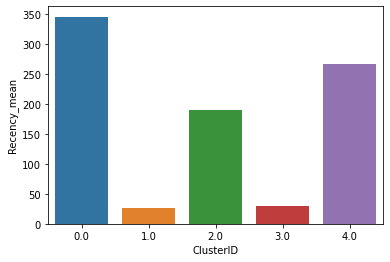

In [164]:
sns.barplot(x=df.ClusterID, y=df.Recency_mean)

## Heirarchical Clustering

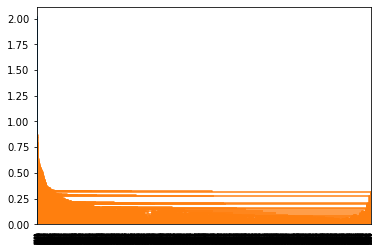

In [165]:
# heirarchical clustering
mergings = linkage(RFM_norm1, method = "single", metric='euclidean')
dendrogram(mergings)
plt.show()

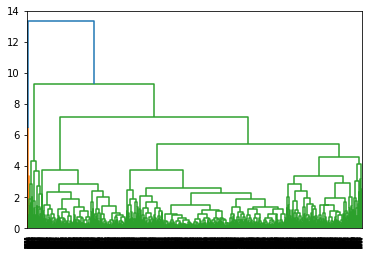

In [166]:
mergings = linkage(RFM_norm1, method = "complete", metric='euclidean')
dendrogram(mergings)
plt.show()

In [167]:
clusterCut = pd.Series(cut_tree(mergings, n_clusters = 5).reshape(-1,))
RFM_hc = pd.concat([RFM, clusterCut], axis=1)
RFM_hc.columns = ['CustomerID', 'Frequency', 'Amount', 'Recency', 'ClusterID']

In [168]:
#summarise
RFM_hc.Recency = RFM_hc.Recency.dt.days
km_clusters_amount =pd.DataFrame(RFM_hc.groupby(["ClusterID"]).Amount.mean())
km_clusters_frequency =pd.DataFrame(RFM_hc.groupby(["ClusterID"]).Frequency.mean())
km_clusters_recency =pd.DataFrame(RFM_hc.groupby(["ClusterID"]).Recency.mean())

In [169]:
df = pd.concat([pd.Series([0,1,2,3,4]), km_clusters_amount, km_clusters_frequency, km_clusters_recency], axis=1)
df.columns = ["ClusterID", "Amount_mean", "Frequency_mean", "Recency_mean"]
df.head()

,ClusterID,Amount_mean,Frequency_mean,Recency_mean
0,0,19.923729,280.425794,253.149364
1,1,52.817311,819.624547,53.710073
2,2,239.068027,1767.996463,28.850340
3,3,434.368421,1742.419474,24.105263
4,4,693.500000,2222.950000,12.000000


<AxesSubplot:xlabel='ClusterID', ylabel='Amount_mean'>

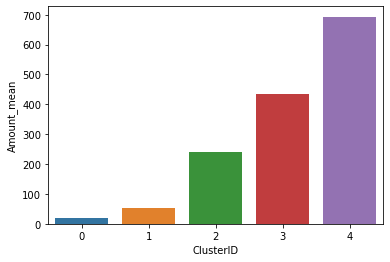

In [170]:
#plotting barplot
sns.barplot(x=df.ClusterID, y=df.Amount_mean)

<AxesSubplot:xlabel='ClusterID', ylabel='Frequency_mean'>

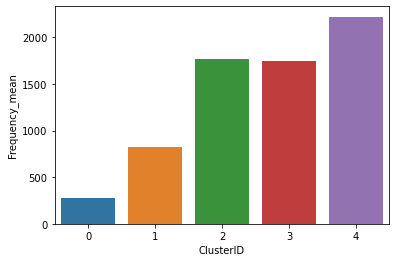

In [171]:
sns.barplot(x=df.ClusterID, y=df.Frequency_mean)

<AxesSubplot:xlabel='ClusterID', ylabel='Recency_mean'>

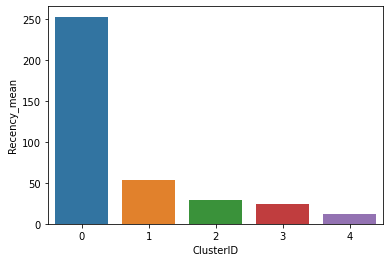

In [172]:
sns.barplot(x=df.ClusterID, y=df.Recency_mean)